<a href="https://colab.research.google.com/github/MahdiTheGreat/MNIST_pytorch_classification/blob/main/MNIST_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipdb
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
import ipdb
# %pdb on

In [4]:
import os
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
SEED = 2024
cache = True

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)

PLOT_SETTINGS = {"text.usetex": False,
                 "font.family": "serif",
                 "figure.figsize": (8.0, 6.0),
                 "font.size": 16,
                 "axes.labelsize": 16,
                 "legend.fontsize": 14,
                 "xtick.labelsize": 14,
                 "ytick.labelsize": 14,
                 "axes.titlesize": 24,
                 "lines.linewidth": 2.0,
                 }
plt.rcParams.update(PLOT_SETTINGS)

# Define a class map manually for MNIST
class_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine"
}

n_epochs=30
batch_size=64
kernel_size=3
pool_size=2
conv_factor=1
dropout=0.2
target_size=len(class_map)

print(f"n_epochs: {n_epochs}")
print(f"batch_size: {batch_size}")
print(f"kernel_size: {kernel_size}")
print(f"pool_size: {pool_size}")
print(f"conv_factor: {conv_factor}")
print(f"dropout: {dropout}")
print(f"target shape: {target_size}")


n_epochs: 30
batch_size: 64
kernel_size: 3
pool_size: 2
conv_factor: 1
dropout: 0.2
target shape: 10


In [6]:
import torch
from torchvision import datasets, transforms

# Define the transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST-specific mean and std
])

# Download and load the training set
train_dataset = datasets.MNIST(
    root='mnist_data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the test set
test_dataset = datasets.MNIST(
    root='mnist_data',
    train=False,
    download=True,
    transform=transform
)

# Optional: create DataLoaders to iterate over the dataset in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the data
images, labels = next(iter(train_loader))
print(f'Image batch shape: {images.shape}')
print(f'Label batch shape: {labels.shape}')

image_shape=list(images.shape)
images=images.numpy().reshape((image_shape[0],*image_shape[2:len(image_shape)]))
labels=labels.numpy()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 17838730.02it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 492930.48it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4477165.77it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 7586829.46it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


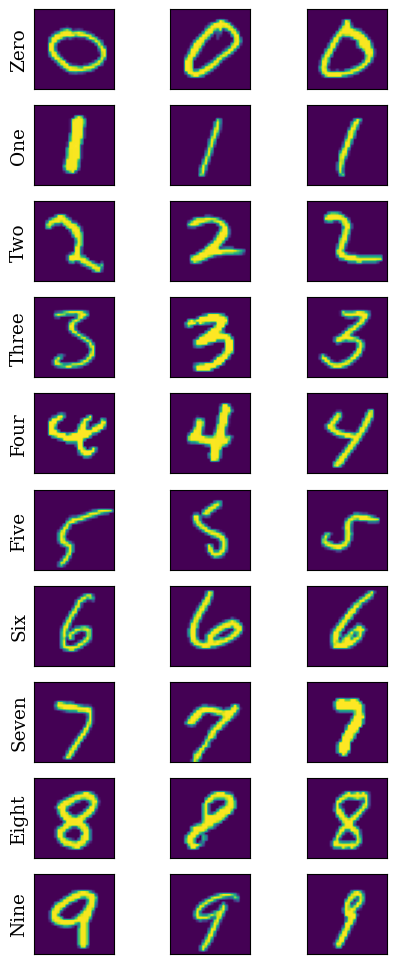

In [7]:
def img_data_plotter(imgs,lbls,class_map,N=10,figsize=None,top=None):
 # Plot a few of the training images
 M=len(list(class_map))

 fig = plt.figure(figsize=figsize)
 #fig.subplots_adjust(top=0.995, bottom=0.005, left=0.025,right=0.995,wspace=0.05,hspace=0.0125)
 fig.subplots_adjust(top=top)
 axs = []
 for m in range(M):
     axs.append([])
     for n in range(N):
         ax = plt.subplot2grid((M, N), (m, n), rowspan=1, colspan=1)
         ax.xaxis.set_ticklabels([])
         ax.xaxis.set_ticks([])
         ax.yaxis.set_ticklabels([])
         ax.yaxis.set_ticks([])
         axs[m].append(ax)

 indices = [0] * M

 for i in range(len(imgs)):
     y = lbls[i]
     if indices[y] < N:
      axs[y][indices[y]].imshow(imgs[i])  # int [0,...,255]
      indices[y] += 1

 for m in range(M):
     axs[m][0].set_ylabel(f"{class_map[m]}", size='small')

 # plt.tight_layout()
 plt.show()
 plt.close()

img_data_plotter(imgs=images,N=3,lbls=labels,class_map=class_map,figsize=(5, 5),top=2)

In [20]:
import numpy as np

def calculate_layer_sizes(input_size, output_size, num_hidden_layers):
    # Calculate the scale down factor
    scale_down_factor = (output_size / input_size) ** (1 / (num_hidden_layers + 1))

    # Calculate the size of each layer
    layer_sizes = [int(input_size * (scale_down_factor ** i)) for i in range(num_hidden_layers + 2)]

    # Ensure the last layer size is exactly the output size
    layer_sizes[-1] = output_size
    return layer_sizes

# Example usage
input_size = np.prod(images.shape[1:])      # Example input size
output_size = len(class_map)      # Example output size
num_hidden_layers = 2 # Example number of hidden layers

layer_sizes = calculate_layer_sizes(input_size, output_size, num_hidden_layers)
print("Layer sizes:", layer_sizes)

Layer sizes: [784, 183, 42, 10]


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

In [68]:
class SimpleANN(nn.Module):

    def __init__(self,layer_sizes,activation=nn.ReLU,last_layer_activation=nn.ReLU):

        super(SimpleANN, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layer_sizes)-2):
          self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
          self.layers.append(activation())
          self.layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.layers.append(last_layer_activation())
        self.layers.append(nn.Dropout(dropout))

    def forward(self, x):
        x = x.view(-1, np.prod(x.shape[1:])) # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

In [69]:
model = SimpleANN(layer_sizes=layer_sizes)
criterion = nn.CrossEntropyLoss()          # Suitable loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
print(model)

SimpleANN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=183, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=183, out_features=42, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=42, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
)


In [76]:
def train_model(model, train_loader, criterion, optimizer, n_epochs):
 for epoch in range(n_epochs):
   model.train()
   for images, labels in train_loader:
       # Forward pass
       outputs = model(images)
       loss = criterion(outputs, labels)

       # Backward pass and optimization
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

   print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')



In [77]:
train_model(model=model, train_loader=train_loader, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs)

KeyboardInterrupt: 

In [74]:
def test_model(model, test_loader):
 model.eval()
 correct = 0
 total = 0

 with torch.no_grad():
     for images, labels in test_loader:
         outputs = model(images)
         _, predicted = torch.max(outputs, 1)
         total += labels.size(0)
         correct += (predicted == labels).sum().item()

 accuracy = 100 * correct / total
 print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

In [75]:
test_model(model=model,test_loader=test_loader)

Accuracy of the model on the test images: 91.27%
